# Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 07.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
import sys
sys.path.append("../../autotalker")

In [2]:
from datetime import datetime

import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scib

from autotalker.benchmarking import compute_benchmarking_metrics

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 43052), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 43068), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=62, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 43082), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/c

### 1.2 Define Parameters

In [3]:
dataset = "squidpy_seqfish_mouse_organogenesis"
cell_type_key = "celltype_mapped_refined"
latent_key = "deeplinc_latent"
active_gp_names_key = "deeplinc_active_gp_names"
spatial_key = "spatial"
leiden_resolution = 0.3
random_seed = 0

### 1.3 Run Notebook Setup

In [4]:
sc.set_figure_params(figsize=(6, 6))

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../datasets/srt_data/gold/"
figure_folder_path = f"../figures/{dataset}/benchmarking/"
benchmark_data_folder_path = "../datasets/benchmark_data/"

## 2. Data

In [7]:
# Load Data
adata = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")

In [9]:
# Compute benchmarking metrics for DeepLinc models
benchmarking_dict_list = []
# for run_number, n_neighbors in zip(np.arange(1, 11), [2, 2, 4, 4, 8, 8, 16, 16, 32, 32]):
for run_number, n_neighbors in zip(np.arange(1, 3), [2, 2]):
    benchmarking_dict = {}
    
    # autotalker metrics
    benchmarking_dict = compute_benchmarking_metrics(adata=adata,
                                                     spatial_model=True,
                                                     latent_key=latent_key + f"_run{run_number}",
                                                     active_gp_names_key=active_gp_names_key,
                                                     cell_type_key=cell_type_key,
                                                     spatial_key="spatial",
                                                     spatial_knng_key = f"deeplinc_spatial_{n_neighbors}nng",
                                                     latent_knng_key = f"deeplinc_latent_{n_neighbors}nng",
                                                     n_neighbors=n_neighbors)
    
    # scib metrics
    sc.pp.neighbors(adata=adata,
                    use_rep=latent_key + f"_run{run_number}")
    scib.me.cluster_optimal_resolution(adata=adata,
                                       cluster_key="cluster",
                                       label_key=cell_type_key)
    benchmarking_dict["ari"] = scib.me.ari(adata,
                                           cluster_key="cluster",
                                           label_key=cell_type_key)
    benchmarking_dict["clisi"] = scib.me.clisi_graph(adata=adata,
                                                     label_key=cell_type_key,
                                                     type_="embed",
                                                     use_rep=latent_key + f"_run{run_number}")
    benchmarking_dict["nmi"] = scib.me.nmi(adata=adata,
                                           cluster_key="cluster",
                                           label_key=cell_type_key)
    benchmarking_dict["asw"] = scib.me.silhouette(adata=adata,
                                                  label_key=cell_type_key,
                                                  embed=latent_key + f"_run{run_number}")
    benchmarking_dict["isolated_labels_asw"] = scib.me.isolated_labels_asw(adata=adata,
                                                                           batch_key="sample",
                                                                           label_key=cell_type_key,
                                                                           embed=latent_key + f"_run{run_number}")
    
    benchmarking_dict["model"] = "deeplinc"
    benchmarking_dict["run"] = run_number
    benchmarking_dict_list.append(benchmarking_dict)
df = pd.DataFrame(benchmarking_dict_list)

resolution: 0.1, nmi: 0.1460711389323943
resolution: 0.2, nmi: 0.2788425777549914
resolution: 0.3, nmi: 0.3624194426537873
resolution: 0.4, nmi: 0.3960541259384599
resolution: 0.5, nmi: 0.4103523837687169
resolution: 0.6, nmi: 0.4190425357060047
resolution: 0.7, nmi: 0.446932847437658
resolution: 0.8, nmi: 0.44784439847684887
resolution: 0.9, nmi: 0.4466037140793616
resolution: 1.0, nmi: 0.4436325196525985
resolution: 1.1, nmi: 0.4424248074015207
resolution: 1.2, nmi: 0.45169442006830074
resolution: 1.3, nmi: 0.43857815852884163
resolution: 1.4, nmi: 0.4374476529339145
resolution: 1.5, nmi: 0.4307404064913363
resolution: 1.6, nmi: 0.4326218175112338
resolution: 1.7, nmi: 0.42924194380211567
resolution: 1.8, nmi: 0.42646650062098374
resolution: 1.9, nmi: 0.4228323581985222
resolution: 2.0, nmi: 0.4221252518692213
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.2
optimal score: 0.45169442006830074
isolated labels: no more than 1 batches per label
Allant

In [10]:
df.columns

Index(['gcd', 'mlnmi', 'cad', 'arclisi', 'germse', 'cca', 'ari', 'clisi',
       'nmi', 'asw', 'isolated_labels_asw', 'model', 'run'],
      dtype='object')

In [13]:
mean_df = df.groupby("model").mean()

In [14]:
mean_df

,gcd,mlnmi,cad,arclisi,germse,cca,ari,clisi,nmi,asw,isolated_labels_asw,run
model,,,,,,,,,,,,
deeplinc,241.470495,0.436517,102.259808,1.240170e-07,0.880605,0.763597,0.295513,0.89142,0.453659,0.488166,0.510282,1.5


In [ ]:
mean_df.columns

In [11]:
columns = ["gcd", "mlnmi", "cad", "arclisi", "germse", "cca", "ari", "clisi",
           "nmi", "asw", "isolated_labels_asw"]

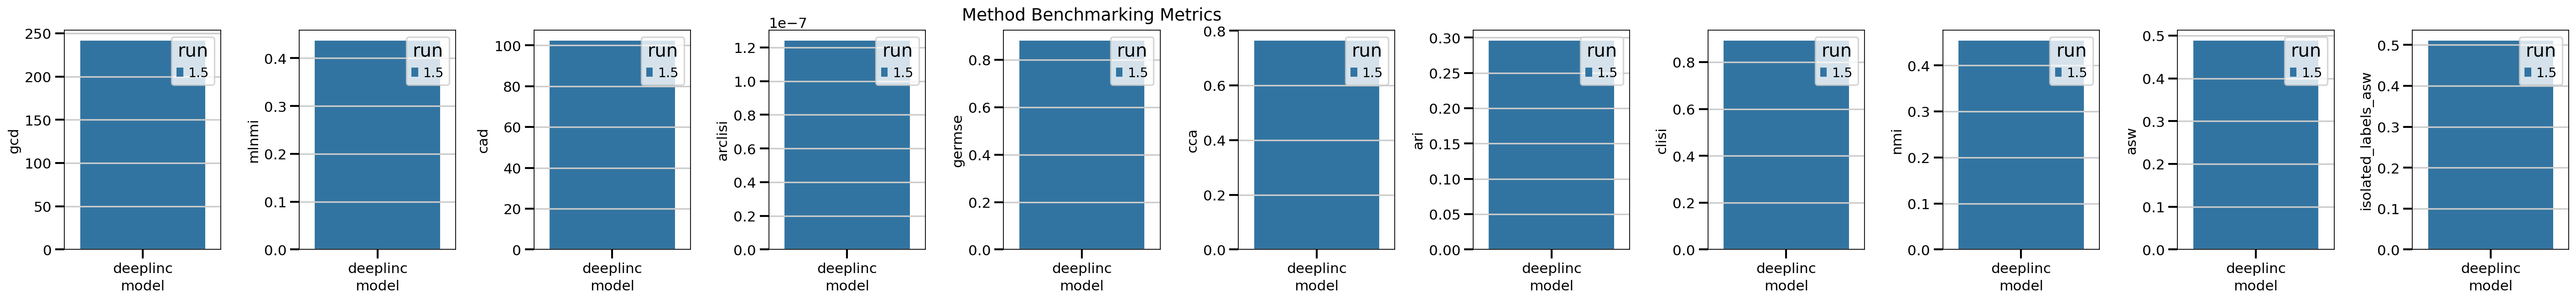

In [15]:
fig, axs = plt.subplots(1, len(columns), figsize=(4*len(columns), 4))

# Plot each column in a separate subplot
for ax, col in zip(axs, columns):
    sns.barplot(data=mean_df, x=mean_df.index, y=col, hue="run", ax=ax)
plt.suptitle("Method Benchmarking Metrics")
plt.subplots_adjust(wspace=0.5, top=0.9)
plt.show()